https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os, sys

from custom_functions import *
from datetime import time
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE

%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('display.max_columns', 100)

RANDOM_STATE = 1000

raw_terry_path = os.path.join('..', 'data', 'raw', 'terry-stops.csv')
processed_data_path = os.path.join('..', 'data', 'processed')
UNKNOWN = 'Not provided'

In [2]:
df = pd.read_csv(raw_terry_path, dtype='str')

# Strip spaces, as relevant
for col in df.columns:
    df[col] = df[col].str.strip()

In [3]:
# ------ CLEAN DATA ONE COLUMN AT A TIME -------

# Subject Age Group
df['Subject Age Group'].replace('-', np.nan, inplace=True)

# Subject ID
df['Subject ID'].replace('-1', UNKNOWN, inplace=True)

# Weapon Type
weapon_type_dict = {'Firearm Other': 'Firearm', 
                    'Lethal Cutting Instrument': 'Knife', 
                    'Handgun': 'Firearm', 
                    '-': 'None', 
                    'Club, Blackjack, Brass Knuckles': 'Blunt/Striking', 
                    'Knife/Cutting/Stabbing Instrument': 'Knife', 
                    'Other Firearm': 'Firearm', 
                    'Rifle': 'Firearm', 
                    'Fire/Incendiary Device': 'Other', 
                    'Blunt Object/Striking Implement': 'Blunt/Striking', 
                    'Firearm (unk type)': 'Firearm', 
                    'Mace/Pepper Spray': 'Other', 
                    'None/Not Applicable': 'None', 
                    'Club': 'Blunt/Striking', 
                    'Taser/Stun Gun': 'Other', 
                    'Shotgun': 'Other', 
                    'Brass Knuckles': 'Blunt/Striking', 
                    'Automatic Handgun': 'Firearm', 
                    'Blackjack': 'Blunt/Striking', 
                    'Personal Weapons (hands, feet, etc.)': 'Blunt/Striking'}
df['Weapon Type'].replace(weapon_type_dict, inplace=True)



# Officer Year of Birth
df['Officer YOB'] = df['Officer YOB'].astype('int')



# Officer Race
race_dict = {'Unknown': np.nan, 
            'Not Specified': np.nan,
            '-': np.nan,
            'Other': np.nan, 
            'Unknown': np.nan}
df['Officer Race'].replace(race_dict, inplace=True)
df['Subject Perceived Race'].replace(race_dict, inplace=True)



# Subject Perceived Gender
gender_dict = {'Unable to Determine': np.nan,
              '-': np.nan,
               'Unknown': np.nan,
              'Gender Diverse (gender non-conforming and/or transgender)': 'Non-Binary',
               'N': 'Non-Binary',
               'M': 'Male',
               'F': 'Female'}
df['Subject Perceived Gender'].replace(gender_dict, inplace=True)
df['Officer Gender'].replace(gender_dict, inplace=True)



# Reported date and hour
df['Reported Date'] = df['Reported Date'].astype('datetime64')
    
    
# Call Type
call_type_dict = {'-': UNKNOWN,
                 'SCHEDULED EVENT (RECURRING)': UNKNOWN,
                 'TEXT MESSAGE': UNKNOWN}
df['Call Type'].replace(call_type_dict, inplace=True)
    
    
# Frisk Flag
df['Frisk Flag'].replace('-', np.nan, inplace=True)

# Precinct
precinct_dict = {'-': UNKNOWN,
                'FK ERROR': UNKNOWN,
                 'Unknown': UNKNOWN,
                'SouthWest': 'Southwest'}
df['Precinct'].replace(precinct_dict, inplace=True)


# Sector
df['Sector'].replace(['99', '-'], UNKNOWN, inplace=True)

# Beat
df['Beat'].replace(['S', '99', '-'], UNKNOWN, inplace=True)

# Subject age group
df['Subject Age Group'].replace('-', np.nan, inplace=True)

df.dropna(inplace=True)

# Feature Engineering

### Age group manipulation

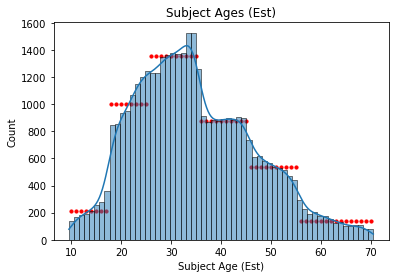

In [4]:
# ------ ESTIMATE SUBJECT AGE ------

years_in_category = {'1 - 17': [10, 17],
'18 - 25': [18, 25],
'26 - 35': [26, 35],
'36 - 45': [36, 45],
'46 - 55': [46, 55],
'56 and Above': [56, 70]}

def predict_ages():
    avg, std, x, y = calculate_mean_and_std()    
    ages = []
    for age_categorical in df['Subject Age Group']:
        age = predict_age_from_category(age_categorical, avg, std)
        ages.append(age)
    return ages, x, y


def calculate_mean_and_std():
    xy = {}
    age_group_counts = dict(df['Subject Age Group'].value_counts())
    
    for age_group in df['Subject Age Group'].replace(UNKNOWN, np.nan).dropna().unique():
        age_range_list = set_range(age_group)
        age_range_ct = age_group_counts[age_group]
        
        for item in age_range_list:
            xy[item] = int(age_range_ct/len(age_range_list))
    
    x = np.array(list(xy.keys()))
    y = np.array(list(xy.values()))
    avg = x.mean()
    std = x.std()
    return avg, std, x, y



def set_range(age_range):
    age_range = years_in_category[age_range]
    start = age_range[0]
    stop = age_range[1]
    return np.linspace(start, stop, stop-start+1)

def predict_age_from_category(bucket, avg, std):
    if bucket == UNKNOWN:
        year_range = np.array(list(years_in_category.values())).flatten()
        min_age = year_range.min()
        max_age = year_range.max()
    else:
        year_range = years_in_category[bucket]
        min_age = year_range[0]
        max_age = year_range[1]
    age = 0
    while ((age <= min_age-0.5) or (age > max_age+0.5)):
        age = np.random.normal(avg, std)
    return age


plt.figure()
df['Subject Age (Est)'], x, y = predict_ages()
sns.histplot(df['Subject Age (Est)'], bins=60, kde=True);
plt.scatter(x, y, c='r', s=10)
plt.title('Subject Ages (Est)');

In [5]:
df['Weapon Type'].value_counts()

None              37114
Knife              1832
Firearm             393
Blunt/Striking      122
Other                38
Name: Weapon Type, dtype: int64

In [6]:
# Engineer new features

# Calculate Officer Age
if 'Officer YOB' in df.columns:
    df['Officer Age'] = df['Reported Date'].apply(lambda x: x.year) - df['Officer YOB']
    df['Officer Age'] = df['Officer Age'].apply(lambda x: np.nan if x > 100 else x)
    df.drop('Officer YOB', axis=1, inplace=True)

    
# Determine whether or not weapon was involved
#has_weapon = lambda x: 'No' if x == 'None' else 'Yes'
df['Weapon (Y/N)'] = (df['Weapon Type'] != 'None').astype('int')


# Calculate the number of stops per subject
if 'Subject ID' in df.columns:
    offense_ct_dict = dict(df['Subject ID'].value_counts())
    df['Offense Count'] = df['Subject ID'].map(offense_ct_dict)
    # Identify whether a subject has been involved in multiple stops
    df['Repeat Offender (Y/N)'] = (df['Offense Count'] > 1).astype('int')
    # Drop "Offense Count" for now given the number of missing values
    if 'Offense Count' in df:
        df.drop('Offense Count', axis=1, inplace=True)
    df.drop('Subject ID', axis=1, inplace=True)


# Identify whether race of officer is same as race of subject
df['Same Race (Y/N)'] = (df['Officer Race'] == df['Subject Perceived Race']).astype('int')

# Identify whether gender of officer is same as gender of subject
df['Same Gender (Y/N)'] = (df['Officer Gender'] == df['Subject Perceived Gender']).astype('int')

# Rename columns and drop 'na' rows
if 'Arrest Flag' in df.columns:
    df['Arrest (Y/N)'] = (df['Arrest Flag'] == 'Y').astype('int')
    df.drop('Arrest Flag', axis=1, inplace=True)
    
if 'Frisk Flag' in df.columns:
    df['Frisk (Y/N)'] = (df['Frisk Flag'] == 'Y').astype('int')
    df.drop('Frisk Flag', axis=1, inplace=True)
    
# Stop resolution
df['Stop Resolution: Arrest (Method2)'] = (df['Stop Resolution'] == 'Arrest').astype('int')


# Revisiting subject perceived gender
# Difficult decision to make, but with a sample size of only 5 people, the 
# amount of data is insufficient to provide a statistically significant understanding
# of how non-binary perception affects arrest rate
df['Subject Perceived Gender'].replace('Non-Binary', np.nan, inplace=True)


# Optionally categorize 'Officer Squad'
# Officer Squad

In [7]:
# Remove missing values and reset index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39495 entries, 0 to 39494
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Subject Age Group                  39495 non-null  object        
 1   GO / SC Num                        39495 non-null  object        
 2   Terry Stop ID                      39495 non-null  object        
 3   Stop Resolution                    39495 non-null  object        
 4   Weapon Type                        39495 non-null  object        
 5   Officer ID                         39495 non-null  object        
 6   Officer Gender                     39495 non-null  object        
 7   Officer Race                       39495 non-null  object        
 8   Subject Perceived Race             39495 non-null  object        
 9   Subject Perceived Gender           39495 non-null  object        
 10  Reported Date                     

### Determine which "Arrest" field to use:
- Option 1: 'Arrest Flag', which is now renamed to 'Arrest (Y/N)'
- Option 2: 'Stop Resolution' value of 'Arrest'

In [9]:
print('Option 1:')
print(df['Arrest (Y/N)'].value_counts())
print('\nOption 2:')
print(df['Stop Resolution: Arrest (Method2)'].value_counts())

Option 1:
0    36449
1     3046
Name: Arrest (Y/N), dtype: int64

Option 2:
0    29293
1    10202
Name: Stop Resolution: Arrest (Method2), dtype: int64


##### Since there are more in Option 2, determine if all positives from Option 1 are included in this subset

In [10]:
# Determine if all of
method2 = df.loc[df['Stop Resolution: Arrest (Method2)']==1].copy()
method2['Arrest (Y/N)'].value_counts()

0    7158
1    3044
Name: Arrest (Y/N), dtype: int64

##### All but 2 of the positive Arrest (Y/N) values are included in 'Stop Resolution: Arrest'. As a result, we see that the former is a subset of the latter. It is unclear why, but for the scope of this analysis, we will use the latter for the sake of a larger scope. 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39495 entries, 0 to 39494
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Subject Age Group                  39495 non-null  object        
 1   GO / SC Num                        39495 non-null  object        
 2   Terry Stop ID                      39495 non-null  object        
 3   Stop Resolution                    39495 non-null  object        
 4   Weapon Type                        39495 non-null  object        
 5   Officer ID                         39495 non-null  object        
 6   Officer Gender                     39495 non-null  object        
 7   Officer Race                       39495 non-null  object        
 8   Subject Perceived Race             39495 non-null  object        
 9   Subject Perceived Gender           39495 non-null  object        
 10  Reported Date                     

In [12]:
df.rename({'Stop Resolution: Arrest (Method2)':'Stop Resolution: Arrest (Y/N)'}, axis=1, inplace=True)
df.drop('Arrest (Y/N)', axis=1, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39495 entries, 0 to 39494
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Subject Age Group              39495 non-null  object        
 1   GO / SC Num                    39495 non-null  object        
 2   Terry Stop ID                  39495 non-null  object        
 3   Stop Resolution                39495 non-null  object        
 4   Weapon Type                    39495 non-null  object        
 5   Officer ID                     39495 non-null  object        
 6   Officer Gender                 39495 non-null  object        
 7   Officer Race                   39495 non-null  object        
 8   Subject Perceived Race         39495 non-null  object        
 9   Subject Perceived Gender       39495 non-null  object        
 10  Reported Date                  39495 non-null  datetime64[ns]
 11  Reported Time  

# Graphical EDA

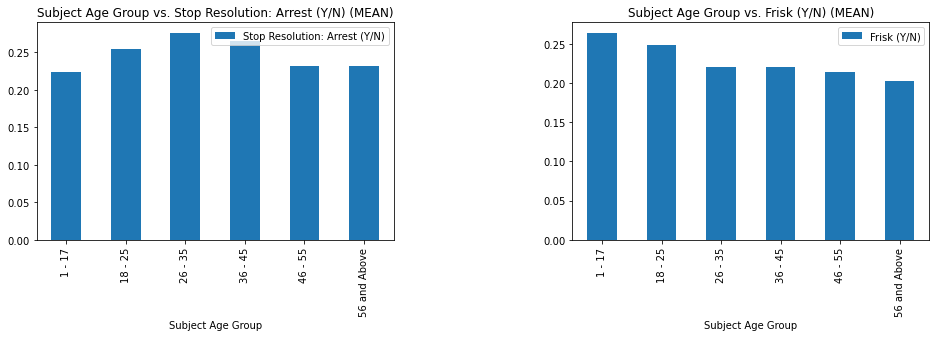

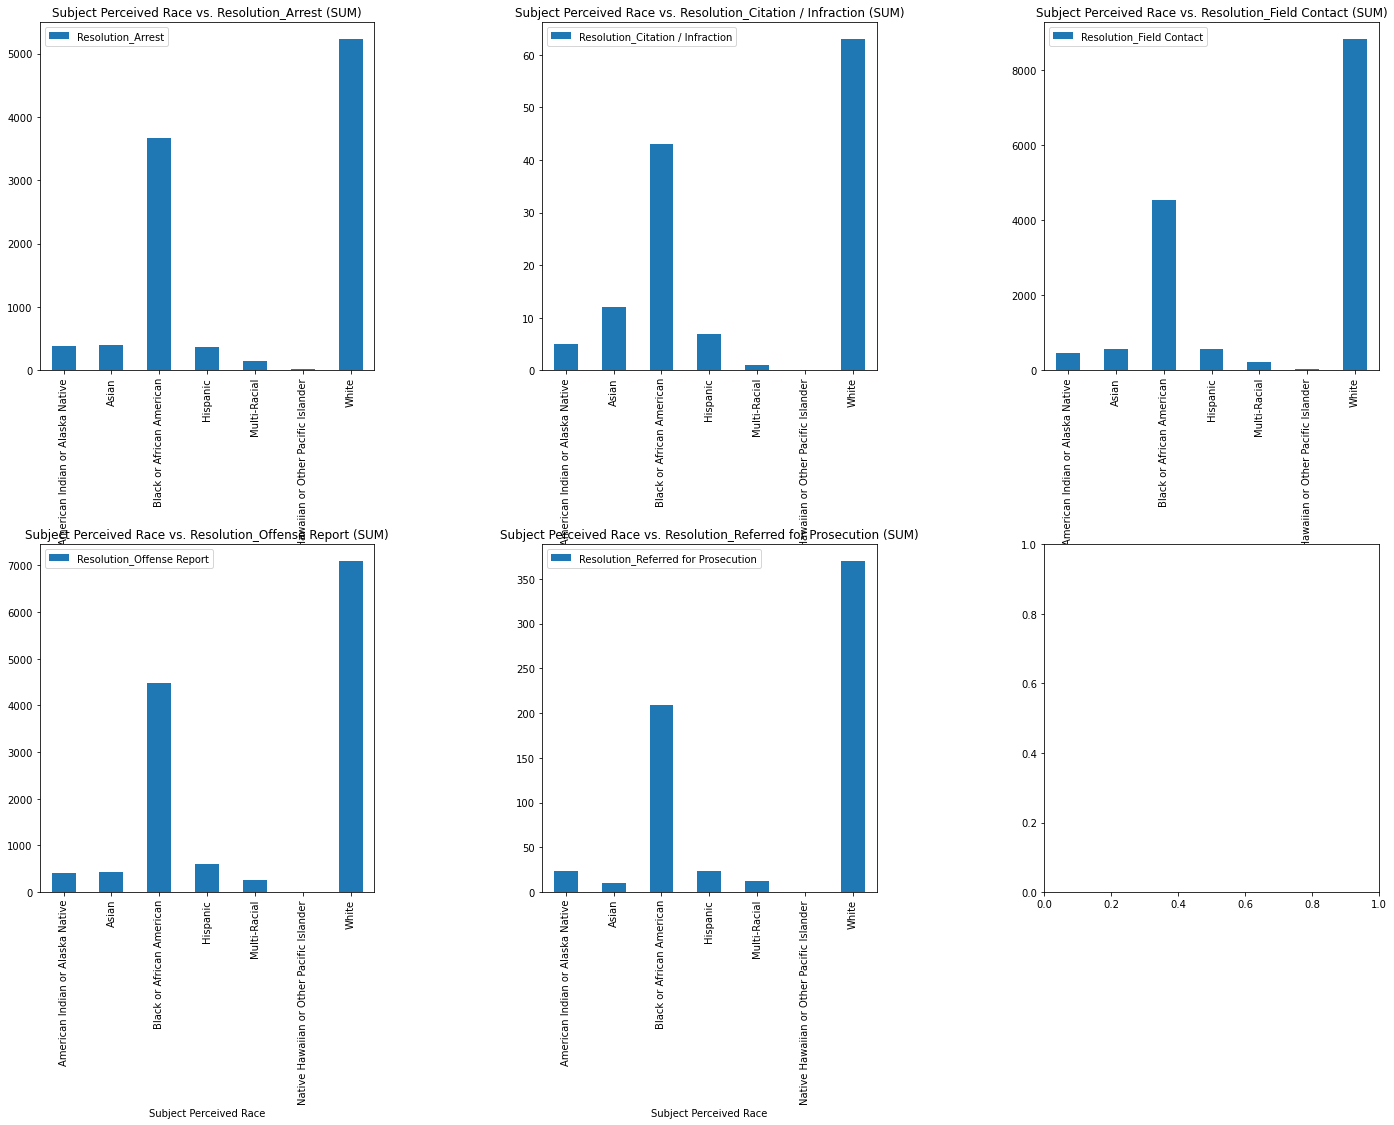

                      Subject Perceived Race  Resolution_Arrest  \
6                                      White             5230.0   
2                  Black or African American             3665.0   
1                                      Asian              401.0   
0           American Indian or Alaska Native              376.0   
3                                   Hispanic              373.0   
4                               Multi-Racial              142.0   
5  Native Hawaiian or Other Pacific Islander               15.0   

   Resolution_Citation / Infraction  Resolution_Field Contact  \
6                              63.0                    8830.0   
2                              43.0                    4544.0   
1                              12.0                     557.0   
0                               5.0                     458.0   
3                               7.0                     579.0   
4                               1.0                     220.0   
5       

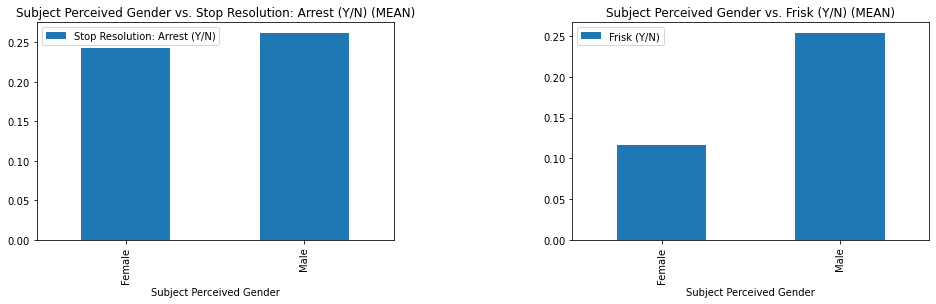

  Subject Perceived Gender  Stop Resolution: Arrest (Y/N)  Frisk (Y/N)
1                     Male                       0.262188     0.254312
0                   Female                       0.243071     0.115730
--------------------------------------------------------------------




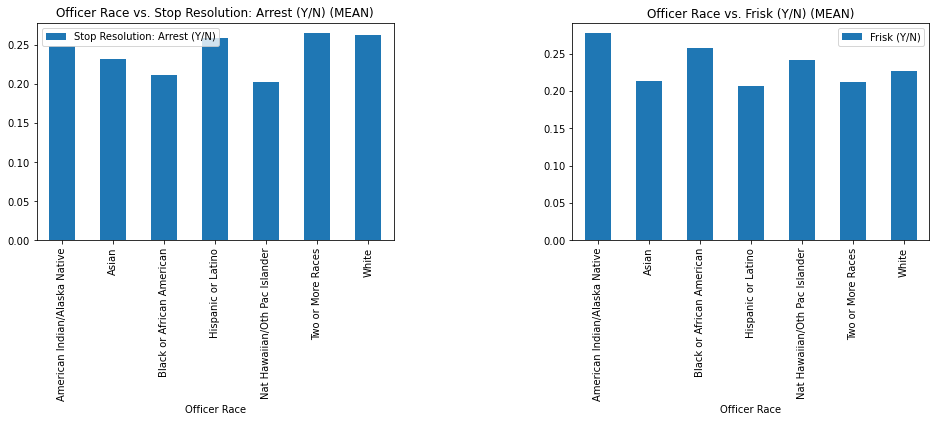

                    Officer Race  Stop Resolution: Arrest (Y/N)  Frisk (Y/N)
5              Two or More Races                       0.265077     0.211521
6                          White                       0.262261     0.227299
3             Hispanic or Latino                       0.259008     0.206443
0  American Indian/Alaska Native                       0.248175     0.277372
1                          Asian                       0.232504     0.213418
2      Black or African American                       0.211126     0.258043
4  Nat Hawaiian/Oth Pac Islander                       0.202597     0.241558
--------------------------------------------------------------------




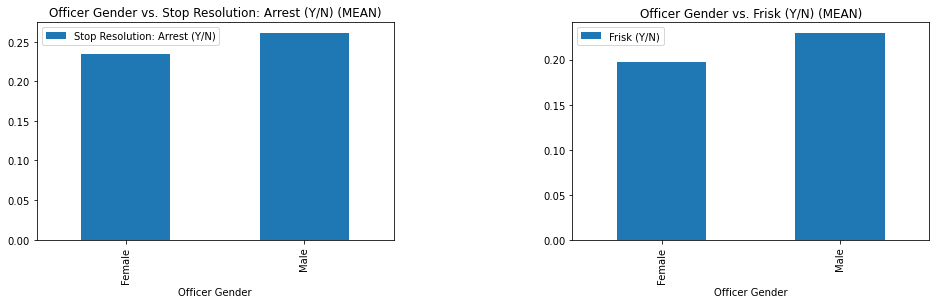

  Officer Gender  Stop Resolution: Arrest (Y/N)  Frisk (Y/N)
1           Male                       0.261355     0.229894
0         Female                       0.234827     0.197749
--------------------------------------------------------------------




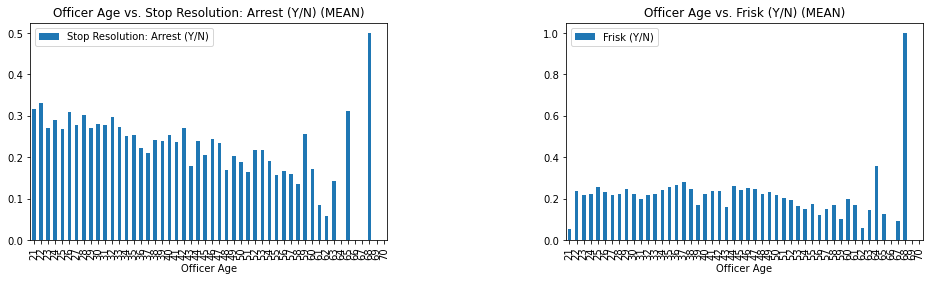

    Officer Age  Stop Resolution: Arrest (Y/N)  Frisk (Y/N)
47           68                       0.500000     1.000000
1            22                       0.330317     0.235294
0            21                       0.315789     0.052632
44           65                       0.312500     0.125000
5            26                       0.309610     0.233247
7            28                       0.302947     0.224678
11           32                       0.297089     0.218322
3            24                       0.289913     0.221109
9            30                       0.281110     0.223582
6            27                       0.278135     0.215970
10           31                       0.276836     0.196610
12           33                       0.273577     0.224299
21           42                       0.271144     0.236318
8            29                       0.270588     0.248366
2            23                       0.270481     0.217165
4            25                       0.

In [14]:
# BAR GRAPHS FOR ***AVERAGE OR SUM*** OF METRICS

df_graphical = pd.concat([df, pd.get_dummies(df['Stop Resolution'], prefix='Resolution')], axis=1)

# Average metrics by age group
x_axis = 'Subject Age Group'
y_axis = ['Stop Resolution: Arrest (Y/N)', 'Frisk (Y/N)']#, 'Resolution_Arrest', 'Resolution_Citation / Infraction', 'Resolution_Field Contact', 'Resolution_Offense Report', 'Resolution_Referred for Prosecution']
bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=False)

# Average metrics by subject race
x_axis = 'Subject Perceived Race'
y_axis = ['Resolution_Arrest', 'Resolution_Citation / Infraction', 'Resolution_Field Contact', 'Resolution_Offense Report', 'Resolution_Referred for Prosecution']
bar_plot(df_graphical, x_axis, y_axis, 'sum', verbose=True)

# Gender metrics
x_axis = 'Subject Perceived Gender'
y_axis = ['Stop Resolution: Arrest (Y/N)', 'Frisk (Y/N)']
bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# Officer race
x_axis = 'Officer Race'
bar_plot(df_graphical, x_axis, y_axis, 'mean',verbose=True)

# Officer gender
x_axis = 'Officer Gender'
bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# Officer age
x_axis = 'Officer Age'
bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# Refine dataset

In [15]:
# Refine dataset to continuous and categoricals w/reasonable number of unique values

# Separate columns by type
obj_columns = df.select_dtypes('object').columns
continuous_columns = df.drop(obj_columns, axis=1).columns

# Determine which columns are most valuable to OHE
# based on small enough number of values
cols_to_ohe = []
for col in obj_columns:
    if len(df[col].value_counts().index) < 30:
        cols_to_ohe.append(col)
    else:
        print('Excluding:', col)

df_refined = pd.concat([df[continuous_columns], df[cols_to_ohe]], axis=1)

print(f'Including: {df_refined.columns}')
#df_refined.info()

Excluding: GO / SC Num
Excluding: Terry Stop ID
Excluding: Officer ID
Excluding: Reported Time
Excluding: Initial Call Type
Excluding: Final Call Type
Excluding: Officer Squad
Excluding: Beat
Including: Index(['Reported Date', 'Subject Age (Est)', 'Officer Age', 'Weapon (Y/N)',
       'Repeat Offender (Y/N)', 'Same Race (Y/N)', 'Same Gender (Y/N)',
       'Frisk (Y/N)', 'Stop Resolution: Arrest (Y/N)', 'Subject Age Group',
       'Stop Resolution', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Call Type',
       'Precinct', 'Sector'],
      dtype='object')


##### Plot distributions

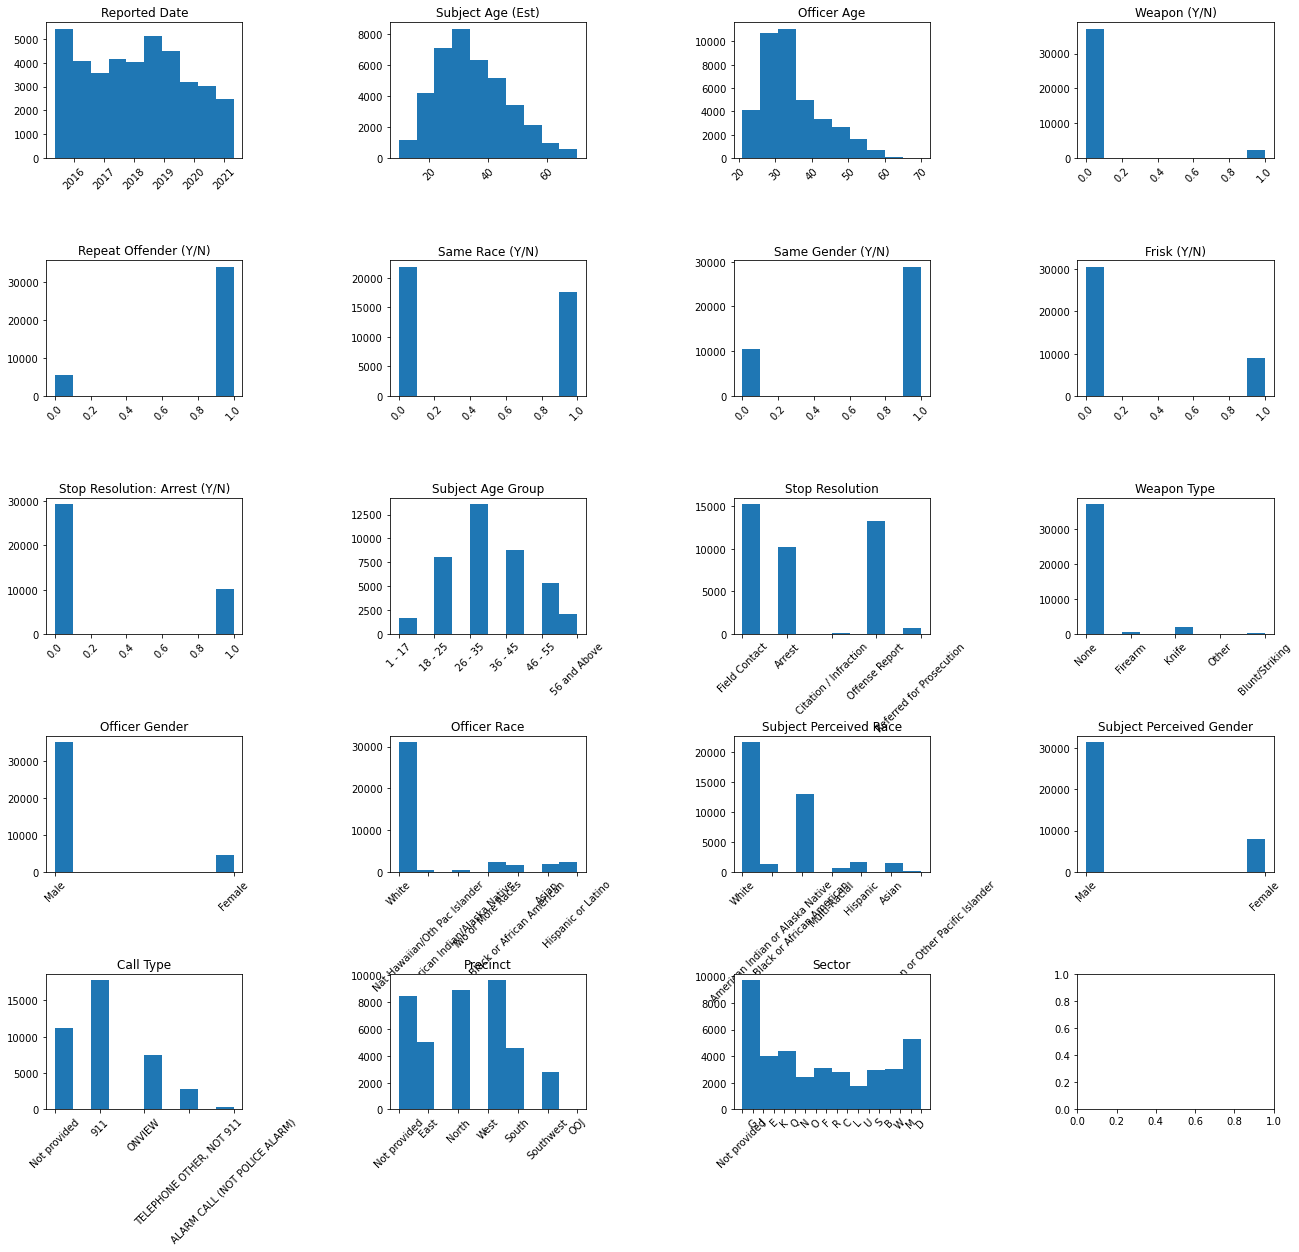

In [16]:
#nrows = int(np.ceil(len(continuous_columns)/4))
nrows = int(np.ceil(df_refined.shape[1]/4))
fig, axes = plt.subplots(ncols=4, nrows=nrows, figsize=(22, 4*nrows))

for ax, col in zip(axes.flatten(), df_refined.columns):
    ax.hist(df_refined[col])
    ax.set_title(col)
    ax.tick_params('x', labelrotation=45)
    #ax.tick_params(labelrotation=45)
    
plt.subplots_adjust(wspace=.75, hspace=.75)

# Begin encoding and modeling

In [17]:
# OPTIONAL APPROACH: REMOVE ROWS WITH ANY UNKNOWNS (precinct, mostly)
# df_refined_no_nas = df_refined.copy()
# for col in df_refined_no_nas.columns:
#     df_refined_no_nas.replace(UNKNOWN, np.nan, inplace=True)

# df_refined_no_nas.dropna(inplace=True)
# df_refined_no_nas.info()

In [18]:
df['Call Type'].value_counts()

911                              17799
Not provided                     11186
ONVIEW                            7428
TELEPHONE OTHER, NOT 911          2791
ALARM CALL (NOT POLICE ALARM)      291
Name: Call Type, dtype: int64

In [21]:
# Split data
y_label = 'Stop Resolution: Arrest (Y/N)'
X = df_refined.drop([y_label,
                     'Frisk (Y/N)', 
                     'Reported Date', 
                     'Subject Age Group', 
                     'Call Type'], 
                     #'Precinct',
                     #'Sector'], 
                     axis=1)
y = df_refined[y_label]

X, X_test, y, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

# Remove temptation to touch test dataset
test_data = {'X_test': X_test, 'y_test': y_test}
with open (os.path.join(processed_data_path, 'test_data.pickle'), 'wb') as f:
    pickle.dump (test_data, f)
X_test = None
y_test = None
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Declare object to hold history of all model runs
model_history = ModelHistory()

In [ ]:
# --- BASELINE MODEL ---
model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
X_numeric = X.select_dtypes(exclude='object')
model.fit(X_numeric, y)
model_history.add_results(model, X_numeric, y, verbose=True)

In [ ]:
# --- ENCODE AND SCALE ---

# ENCODE 'OBJECT' DATATYPES
ohe = OneHotEncoder(drop='first', sparse=False)
X_obj = X.select_dtypes(include='object')
ohe.fit(X_obj)

X_obj_ohe = ohe.transform(X_obj)
col_names_ohe = ohe.get_feature_names(X_obj.columns)
X_obj_ohe = pd.DataFrame(X_obj_ohe, columns = col_names_ohe)
X_numeric = X.drop(X_obj.columns, axis=1)
X_ohe_num = pd.concat([X_obj_ohe, X_numeric], axis=1)

ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X_ohe_num), columns = X_ohe_num.columns)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# NOTES
- Dont use resampling outside of the cross validation - must implement imblearn pipeline

In [ ]:
# --- RUN LOGISTIC REGRESSION MODEL WITH CROSS-VALIDATION ---
model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model.fit(X_resampled, y_resampled)
model_history.add_results(model, X_resampled, y_resampled, verbose=True, cv=3, random_state=RANDOM_STATE);


# --- ADD GRID SEARCH ---
param_grid = {'C': np.logspace(-4, 4, 25)}

# IMPLEMENT KFOLD HERE, PASS IT INTO GRIDSEARCH
cv=KFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

grid_search = GridSearchCV(model, param_grid, cv=cv)
grid_search.fit(X_resampled, y_resampled)
model_history.add_results(grid_search, X_resampled, y_resampled, verbose=True, cv=3, random_state=RANDOM_STATE);

In [ ]:
# --- IMPLEMENT K-NEAREST NEIGHBORS ---
# model = KNeighborsClassifier(random_state=RANDOM_STATE, )
# model.fit(X_resampled, y_resampled)
# model_history.add_results(model, X_resampled, y_resampled, verbose=True, random_state=RANDOM_STATE)

# --- ADD GRID SEARCH ---
# params = {'n_neighbors': np.arange(1,10, 2), 'p': [1,2], 'leaf_size':[3, 5]}
# model = KNeighborsClassifier()#n_neighbors=2, leaf_size=2)
# model.fit(X_resampled, y_resampled)
# grid_search = GridSearchCV(model, params)
# grid_search.fit(X_resampled, y_resampled)
# model_history.add_results(grid_search, X_resampled, y_resampled, verbose=True, cv=5)

In [ ]:
# --- IMPLEMENT DECISION TREE ---
tree = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)
tree.fit(X_resampled, y_resampled)
#tree.feature_importances_

def plot_feature_importances(model, data):
    n_features = data.shape[1]
    plt.figure(figsize=(8, 10))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns.values)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')

plot_feature_importances(tree, X_resampled)

model_history.add_results(tree, X_resampled, y_resampled, verbose=True, cv=3)

# ---  TO DO: ADD GRID SEARCH FOR DECISION TREE! ---

In [ ]:
# --- IMPLEMENT RANDOM FOREST ---
#forest = RandomForestClassifier(max_depth=5, random_state=RANDOM_STATE)
#forest.fit(X_resampled, y_resampled)
#model_history.add_results(forest, X_resampled, y_resampled, verbose=True, cv=3, random_state=RANDOM_STATE)

# --- ADD GRID SEARCH TO RANDOM FOREST ---
param_grid = {
    'n_estimators': [10, 30],#, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

model = RandomForestClassifier(random_state=RANDOM_STATE)
model_grid = GridSearchCV(model, param_grid)
model_grid.fit(X_resampled, y_resampled)
#model_history.add_results(model_grid, X_resampled, y_resampled, verbose=True, cv=5)

In [ ]:
f1_score(y_resampled, model_grid.best_estimator_.predict(X_resampled))

In [ ]:
tp = 13613
fp = 9072
fn = 7935
tn = 14750

tp/(tp+0.5*(fp+fn))

In [ ]:
from sklearn.metrics import plot_confusion_matrix
#confusion_matrix(y_resampled, model_grid.predict(X_resampled))
plot_confusion_matrix(model_grid.best_estimator_, X_resampled, y_resampled)

In [ ]:
# --- IMPLEMENT XGBOOST ---
model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', random_state=RANDOM_STATE)

param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

model.fit(X_resampled, y_resampled, eval_metric='logloss')
model_grid = GridSearchCV(model, param_grid, scoring='f1')
model_grid.fit(X_resampled, y_resampled, eval_metric='logloss')

model_history.add_results(model_grid.best_estimator_, X_resampled, y_resampled, verbose=True, cv=3)

In [ ]:
# --- PLOT FEATURE IMPORTANCE FOR XGBOOST --- 
plot_feature_importances(model_grid.best_estimator_, X_resampled)

### Regarding next steps:
- Where input (e.g. Officer Age) is continuous: run hypothesis test. Alternatively, do bootstapping for categorical

In [ ]:
# --- PLOT TREE FOR RT A FEW CELLS UP
from sklearn.tree import plot_tree

plot_tree(tree, 
          feature_names = X_resampled.columns, 
          class_names=np.unique(y_resampled).astype('str'),
          filled=True, rounded=True)

# To do

- Look into individual cases to see why resolution would be set as Arrest, yet arrest flag was not flipped
- Once a model is selected, how should the results be presented?
- Get KNN running
    - Can also look into what the error is for each side of the decision
    - Back up any sort of conclusion with hypothesis testing
    - If it is a tree-based model, consider printing out the graphical representation of the tree that was used
    - Regarding how to gain meaning from results:
        - Perhaps use hypothesis testing to see extent of results
        - If linear model: bootstrapping can be used to get coefficients - discuss in 1-on-1 next week. 
        - If non-linear (non-parametric) models: once final model is selected, run it again without race (e.g.) to see how error changes. Also see how much the error changes when dropping other features?
    - Could also use step-forward (e.g.) feature selection function that was implemented in the lab project. Make sure to change from R2 eval metric to F1 (or whatever I end up using). Also make sure this is looking at the result on validation data, not just overall data (reduce overfitting). 
  
#### notes: should have but not absolutely necessary
- formulaic feature selection process

# Questions
- Why does F1 get worse for logreg once GridSearch is implemented?
- In cases of grid search, should I be just adding best_estimator_ to the model history to avoid re-running everything within the model history object?
- Discuss age interpolation function
- How do I decide which "arrest metric" to use?
- Is it okay to do the cleaning before splitting like I've done? Or does all that need to be done on the training data then applied to test data?

#### Mention ask next steps:
- Create model for filling in missing ages instead of dropping values

In [ ]:
# --- STRUCTURE FOR PIPELINE ---

# string_selector = make_column_selector(dtype_include='object')
# number_selector = make_column_selector(dtype_exclude=['object', 'datetime'])

# preprocessor = make_column_transformer((ohe, string_selector), (ss, number_selector))
# preprocessor.fit(X, y)

# model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
# pipeline = make_pipeline(preprocessor, model)
# pipeline.fit(X_resampled, y_resampled)
# print('Train:', pipeline.score(X_resampled, y_resampled))